##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas
#%pip install matplotlib
#%pip install numpy
#%pip install xgboost
#%pip install seaborn
#%pip install scikit-learn
#%pip install pyarrow
#%pip install ydata_profiling

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
###...code...###

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
import ydata_profiling as pp
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
df = pd.read_parquet(filepath)
df.to_csv("raw_df.csv", index=False)

def float_conversion(x):
  try:
    return x.astype("float64")
  except ValueError as valErr:
    return x

### EDA before Data Cleaning

EDA before:
- This code will generate a html file containing visualizations of each variable of the raw dataset. We can see the type, the number of missing values, as well as the distribution of the data.
- The html file can be seen in github. It's used to help in the process of data cleaning

- From the html file, we can see that there is a lot of missing value, there is a lot of inconsistent formatting, some columns with 1 value, and the target column is imbalanced

Some Insights
- 98.7% of the data are in from ctrycode_desc Singapore. Therefore, we will focus on Singapore, as the other data points can be considered as outliers.
- We understand clttype as client type, which can be C (Corporate), G (Government/Group), and P (Personal).
- min_occ_date and cltdob_fix will need to be converted to number of years
- Most of the flags features contain about 90% zeroes. There is also consistently 1012 missing values for these features.
- There are more people (>50%) who do not consent to any communication means than those who do. However, there are a lot more who consent to email, mail and sms as compared to calls.
- Most people give valid dm and valid email
- There are about the same number of customers who are class 1 or 2 and those who are not
- hh_size_est has values 0, 1, 2, 3, 4 or >4. We will need to change >4 to 5 to make it numeric.
- Most people (more than 50% of the customers) have low income (below 30k)
- n_months_last_bought_products has values that are negative. There needs to be more research to be done on how the values are gotten.
- The features regarding lapse and cancel (such as recency_lapse and recency_cancel, and those that are tied to individual products such as lapse_ape_inv_dcd836) have 12592 missing values. We can assume that the missing values in recency_lapse and recency_cancel mean that the customers has not lapsed/cancelled before.
For those that have lapsed before, we can see more info in the features n_months_since_lapse_*. If a person uses product ltc_1280bf and lapsed before, he/she will be part of the 30% who have lapsed, and n_months_since_lapse_ltc_1280bf will contain the number of months since he/she lapsed, and for most n_months_since_lapse_(other products) will contain the number 9999.
- The features related to affinity connect contain only the value 1 if they ever show interest, ready to buy, or lapse. If not, the data is missing. We will change it to 0.
- f_purchase_lh contains mostly missing values, with only one distinct value 1. We assume that this means that more than 96% of the customers did not purchase life/health insurance in the end. This is a very imbalanced dataset
- Some products (such as 42e115 and 1280bf) has all 0 values and no missing values. This might mean that there are no customers that use these products.

In [ ]:
profile = pp.ProfileReport(df, minimal=True)
profile.to_file("singlife_datathon_minimal_raw.html")

### Data Cleaning

In the data cleaning process, we did
- Fill missing values with median
- Make the formatting consistent
- Doing one-hot encoding for categorical data
- Filtering country to Singapore only, changing DOB to age to enhance performance of the model
- Dropping redundant columns

In [ ]:
def preprocess(df) :
  # Fill missing values with 0 for these columns
  df[["f_purchase_lh", "recency_lapse", "recency_cancel", "tot_inforce_pols", "tot_cancel_pols"]] = df[["f_purchase_lh", "recency_lapse", "recency_cancel", "tot_inforce_pols", "tot_cancel_pols"]].fillna(0)

  # Change columns with numerical string to float
  string_columns = df.select_dtypes(include=["object"]).columns
  df[string_columns] = df[string_columns].apply(float_conversion)

  # Select flag columns
  flag_columns = df[[col for col in df.columns if col.find("flg_") == 0 or col.find("f") == 0 or col.find("is_") == 0]].columns

  # find flag columns with only 1 value and the rest null
  flag_columns_with_1_value = df[flag_columns[df[flag_columns].nunique() == 1]].columns

  # Convert missing values to either 1 or 0 (depends on the existing value of columns)
  df[flag_columns_with_1_value] = df[flag_columns_with_1_value].apply(lambda x: x.fillna(0) if 1 in x.values else x.fillna(1))

  # Convert missing values & 9999 to 0 in n_months_ columns
  n_months_columns = [col for col in df.columns if col.find("n_months_") == 0]
  df[n_months_columns] = df[n_months_columns].fillna(0)
  df[n_months_columns] = df[n_months_columns].replace(9999, 0)

  # Change column DOB with Age
  df = df.drop(df[(df['cltdob_fix'] == 'None') & (df['f_purchase_lh'] == 0)].index)
  df['cltdob_fix'] = df['cltdob_fix'].replace('None', '1979')
  df['cltdob_fix'] = df['cltdob_fix'].apply(lambda x : 2024 - int(x[0:4]))

  # Change min_occ_date to only year
  df['min_occ_date'] = df['min_occ_date'].apply(lambda x : int(x[0:4]) if x != 'None' else None)

  # Filter country to SG only
  df = df.drop(df[df['ctrycode_desc'] != 'Singapore'].index)
  df = df.drop('ctrycode_desc', axis = 1)

  # Clean up hh_size_est
  df['hh_size_est'] = df['hh_size_est'].replace('>4','5')
  df['hh_size_est'] = df['hh_size_est'].apply(lambda x: None if pd.isna(x) else int(x))

  # Remove columns with majority missing values (Code checks both flag and non-flag columns)
  th = 50
  bool_columns_exceeding_threshold = df.isna().sum()*100/df.shape[0] > th
  columns_to_be_removed = df.columns[bool_columns_exceeding_threshold]
  print("Drop columns with majority missing values")
  print(f"Initial shape: {df.shape}")
  df = df.drop(columns = columns_to_be_removed)
  print(f"End shape: {df.shape}")

  # flag_columns with 1 value and null value should be cleanged by now, so drop those columns with only 1 value (not useful)
  columns_with_1_value = df.columns[df.nunique() == 1]
  print("Drop columns with only 1 distinct value")
  print(f"Initial shape: {df.shape}")
  df = df.drop(columns = columns_with_1_value)
  print(f"End shape: {df.shape}")

  # Fill up the numeric columns' missing values with median value
  numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
  df[numeric_columns] = df[numeric_columns].apply(lambda x: x.fillna(x.median()))

  # One hot encoding categorical columns
  cat_columns = ['race_desc', 'clttype', 'stat_flag', 'cltsex_fix', 'annual_income_est']
  df_cat = df[cat_columns]

  df_encoded = pd.get_dummies(df_cat, columns=cat_columns)
  df = pd.concat([df_encoded, df], axis=1)

  # Removing redundant columns
  columns_drop = ['race_desc_Others',
                  'clttype_C',
                  'stat_flag_MATURED',
                  'cltsex_fix_Female',
                  'annual_income_est_A.ABOVE200K',
                  'race_desc',
                  'clttype',
                  'stat_flag',
                  'cltsex_fix',
                  'annual_income_est',
                  'clntnum']
  df = df.drop(columns=columns_drop)

  print(f"Final shape: {df.shape}")
  print(f"Target columns 0: {len(df[df['f_purchase_lh'] == 0])} entries")
  print(f"Target columns 1: {len(df[df['f_purchase_lh'] == 1])} entries")

  return df

In [ ]:
preprocessed_df = preprocess(df)

Drop columns with majority missing values
Initial shape: (17769, 303)
End shape: (17769, 255)
Drop columns with only 1 distinct value
Initial shape: (17769, 255)
End shape: (17769, 202)
Final shape: (17769, 208)
Target columns 0: 17059 entries
Target columns 1: 710 entries


### EDA after Data Cleaning

In [ ]:
#Hans pls put ur pandas profiling code here
profile = pp.ProfileReport(df, minimal=True)
profile.to_file("singlife_datathon_minimal_cleaned.html")

EDA after:  
- This code will generate a html file containing visualizations of each variable of the cleaned dataset.
- The html file can be seen in github. It's used to help check if the dataset is as clean as we expected.
- We can see the type, the number of missing values, as well as the distribution of the data.

- After we clean the dataset, the missing values are handled, the column with 1 value are dropped, and the formatting become consistent.

### Imbalance Data Handling (Resampling)

To handle the imbalance data, we resample the data. The old ratio is 96:4 and the new ratio of resampled data is 60:40.

In [ ]:
def resampling(df):
  # Specify features and target variable
  X = df.loc[:, df.columns != 'f_purchase_lh']
  y = df['f_purchase_lh']

  # Split the dataset into training and testing sets with stratified sampling
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # Display the shapes of the resulting datasets
  print("Training set", y_train.shape)
  print("Testing set", y_test.shape)

  # Downsample & Resample
  train_data = pd.concat([X_train, y_train], axis = 1)
  train_data_1 = train_data[train_data['f_purchase_lh'] == 1]
  train_data_0 = train_data[train_data['f_purchase_lh'] == 0]
  print(f"Target 1: {train_data_1.shape}")
  print(f"Target 0: {train_data_0.shape}")

  target_1_upsample = resample(train_data_1,
             replace=True,
             n_samples=int(train_data.shape[0]*0.4),
             random_state=42)

  target_0_downsample = resample(train_data_0,
              replace=True,
              n_samples=int(train_data.shape[0]*0.6),
              random_state=42)

  print(f"Target 1: {target_1_upsample.shape}")
  print(f"Target 0: {target_0_downsample.shape}")

  resampled_train_data = pd.concat([target_1_upsample, target_0_downsample], axis = 0)
  print(f"resampled_train_data: {resampled_train_data.shape}")
  resampled_X_train = resampled_train_data.loc[:, resampled_train_data.columns != 'f_purchase_lh']
  resampled_y_train = resampled_train_data['f_purchase_lh']
  print(f"resampled_X_train: {resampled_X_train.shape}")
  print(f"resampled_y_train: {resampled_y_train.shape}")
  return [resampled_X_train, resampled_y_train, X_test, y_test]

In [ ]:
split_data = resampling(preprocessed_df)

Training set (14215,)
Testing set (3554,)
Target 1: (568, 208)
Target 0: (13647, 208)
Target 1: (5686, 208)
Target 0: (8529, 208)
resampled_train_data: (14215, 208)
resampled_X_train: (14215, 207)
resampled_y_train: (14215,)


### Training the Model

# XGBoost

After several trial and analysis, we decided to use 3 models:
- XGBoost
- Decision Tree
- Logistic Regression

Then we made an ensamble of the 3 of them. This combination of model helps to make the model more stable and robust.

In [ ]:
def xgboost(resampled_X_train, resampled_y_train, X_test, y_test) :
  X_train, y_train = resampled_X_train, resampled_y_train

  model = xgb.XGBClassifier(importance_type='gain')
  model.fit(X_train, y_train)

  model = xgb.XGBClassifier(importance_type='gain')

  param_dist = {
      'learning_rate': [0.01, 0.1, 0.3],
      'max_depth': [3, 5, 6],
      'min_child_weight': [1, 3, 5],
      'subsample': [0.8, 1.0],
      'colsample_bytree': [0.8, 1.0],
      'n_estimators': [100, 200, 300]
  }

  # Initialize RandomizedSearchCV
  random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, scoring='f1_weighted', cv=5, random_state=42)

  # Fit the randomized search to the data
  random_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = random_search.best_params_

  model = xgb.XGBClassifier(
      learning_rate=best_params['learning_rate'],
      max_depth=best_params['max_depth'],
      min_child_weight=best_params['min_child_weight'],
      subsample=best_params['subsample'],
      colsample_bytree=best_params['colsample_bytree'],
      n_estimators=best_params['n_estimators'],
      importance_type='gain'
  )

  model.fit(X_train, y_train)

  importance_scores = model.feature_importances_
  feature_names = X_train.columns.tolist()
  sorted_features, sorted_scores = [list(x) for x in zip(*sorted(zip(feature_names, importance_scores), key=lambda x:x[1], reverse=True))]

  selected_features = sorted_features[0:50]
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]

  random_search.fit(X_train_selected, y_train)

  # Get the best parameters
  best_params = random_search.best_params_

  model = xgb.XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_estimators=best_params['n_estimators'],
    importance_type='gain'
  )

  model.fit(X_train_selected, y_train)
  y_pred_selected = model.predict(X_test_selected)

  return model

In [ ]:
xgb_pred = xgboost(split_data[0], split_data[1], split_data[2], split_data[3])

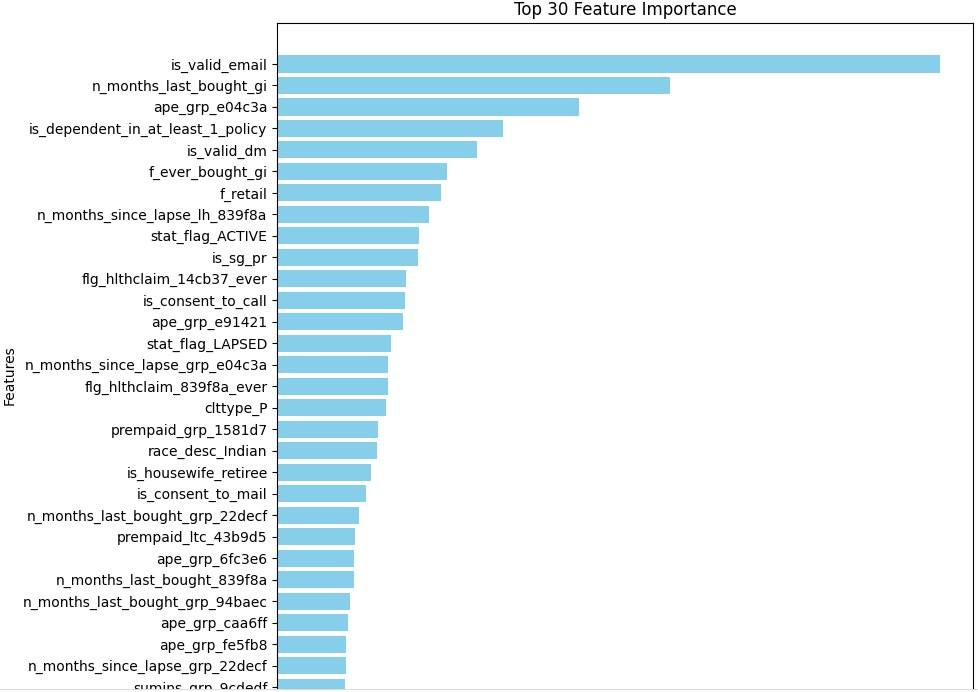

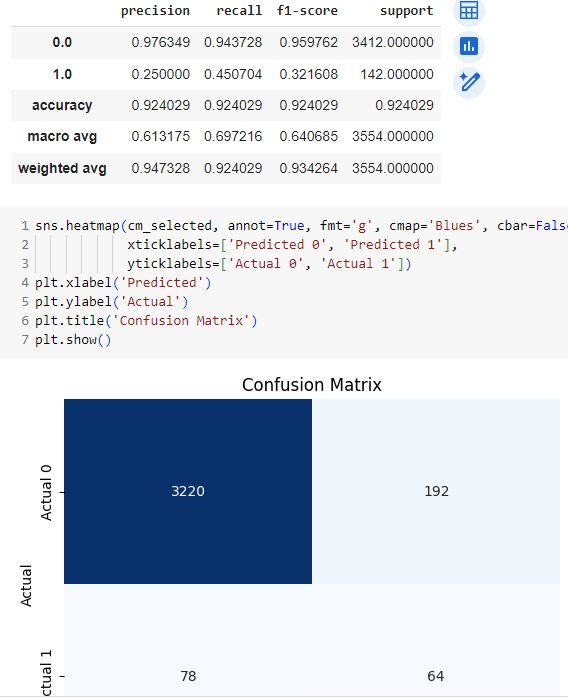

# Decision Tree

In [ ]:
def decision_tree(resampled_X_train, resampled_y_train, X_test, y_test):
  # Initialize the DT for the first hyperparameter tuning
  first_dt = DecisionTreeClassifier(random_state=28)

  # Parameter Distribution for Hyperparameter Tuning
  param_dist = {
      "criterion": ["gini", "entropy"],
      "splitter": ["best", "random"],
      "max_depth": np.arange(5,21).tolist()[0::2],
      'min_samples_split': np.arange(2,11).tolist()[0::2],
      'max_leaf_nodes':np.arange(7,26).tolist()[0::2]
  }

  # Initialize 10 Stratified Fold
  skf = StratifiedKFold(n_splits=10)

  # Random Search of hyperparameters after the training data is fitted in
  first_search = RandomizedSearchCV(first_dt, param_distributions=param_dist, n_iter = 100, scoring="f1_weighted", cv = skf)
  first_hyp = first_search.fit(resampled_X_train, resampled_y_train)
  first_params = first_hyp.best_params_

  # Feature selection
  first_h_DT = DecisionTreeClassifier(criterion=first_params["criterion"],
                              splitter=first_params["splitter"],
                              max_depth=first_params["max_depth"],
                              min_samples_split=first_params["min_samples_split"],
                              max_leaf_nodes=first_params["max_leaf_nodes"],
                              random_state=28)
  first_h_DT.fit(resampled_X_train, resampled_y_train)
  importance_scores = first_h_DT.feature_importances_
  feature_names = resampled_X_train.columns
  sorted_features, sorted_scores = [list(x) for x in zip(*sorted(zip(feature_names, importance_scores), key=lambda x:x[1], reverse=True))]

  # Get top 20
  top_20_sorted_features = sorted_features[0:20]
  top_20_sorted_scores = sorted_scores[0:20]

  # Plotting the bar graph for top 20 features and scores
  plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

  plt.barh(top_20_sorted_features, top_20_sorted_scores, color='skyblue')
  plt.xlabel('Importance Scores')
  plt.ylabel('Features')
  plt.title('Top 20 Feature Importance')

  # Invert the y-axis to have the highest-ranked feature on top
  plt.gca().invert_yaxis()

  plt.tight_layout()  # Ensures labels and titles fit within the plot area
  plt.show()

  # Select the chosen features for both train and test data
  selected_features_X_train = resampled_X_train[top_20_sorted_features]
  selected_features_X_test = X_test[top_20_sorted_features]

  # Initialize the DT for the second hyperparameter tuning
  second_dt = DecisionTreeClassifier(random_state=28)

  # Random Search of hyperparameters after the training data (after feature selection) is fitted in
  second_search = RandomizedSearchCV(second_dt, param_distributions=param_dist, n_iter = 100, scoring="f1_weighted", cv = skf)
  second_hyp = second_search.fit(selected_features_X_train, resampled_y_train)
  second_params = second_hyp.best_params_

  #to fit final tree and plot
  second_h_DT = DecisionTreeClassifier(criterion=second_params["criterion"],
                                splitter=second_params["splitter"],
                                max_depth=second_params["max_depth"],
                                min_samples_split=second_params["min_samples_split"],
                                max_leaf_nodes=second_params["max_leaf_nodes"],
                                random_state=28)
  second_h_DT.fit(selected_features_X_train, resampled_y_train)
  plt.figure(figsize=(16,12))
  plot_tree(second_h_DT, fontsize=12)
  plt.show()

  y_pred = second_h_DT.predict(selected_features_X_test)
  return second_h_DT

In [ ]:
dt_pred = decision_tree(split_data[0], split_data[1], split_data[2], split_data[3])

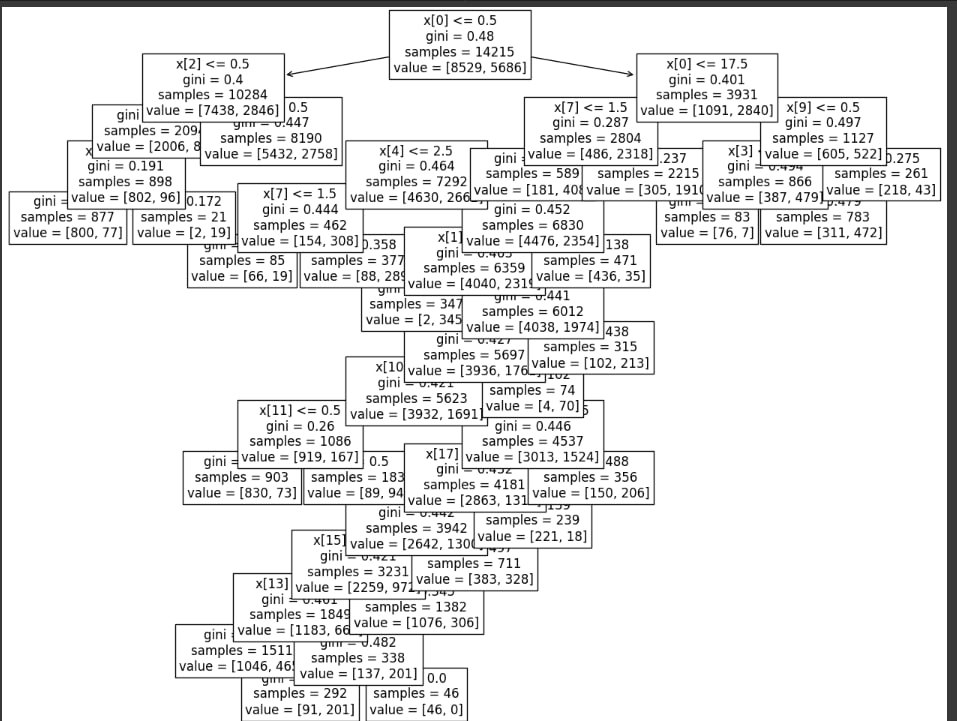

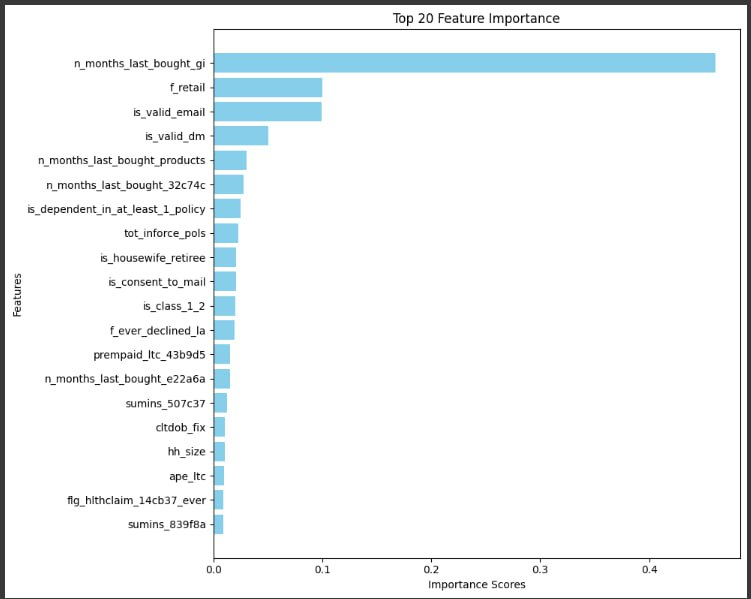

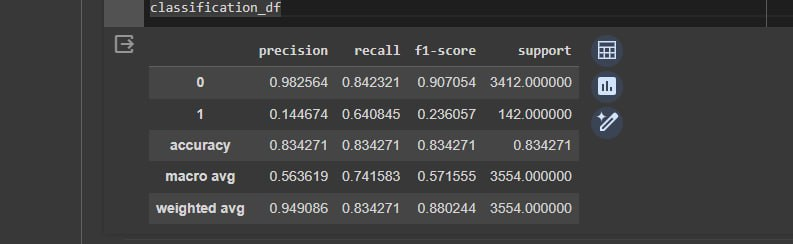

# Logistic Regression

In [ ]:
def log_reg(resampled_X_train, resampled_y_train, X_test, y_test):
  modelLR = LogisticRegression(random_state=28)
  modelLR.fit(resampled_X_train, resampled_y_train)
  coefficients = modelLR.coef_[0]

  feature_importance = pd.DataFrame({'Feature': resampled_X_train.columns, 'Importance': np.abs(coefficients)})
  feature_importance = feature_importance.sort_values('Importance', ascending=False)
  top_20_features = feature_importance[0:20]
  top_20_features.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
  X_train_selected = resampled_X_train[top_20_features['Feature']]
  X_test_selected = X_test[top_20_features['Feature']]


  modelLR.fit(resampled_X_train, resampled_y_train)

  y_pred = modelLR.predict_proba(X_test_selected)
  y_pred = y_pred[:, 1]

  # calculate roc curves
  fpr, tpr, thresholds = roc_curve(resampled_y_train, y_pred)

  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Logistic')
  # Classification threshold = 0.61 is the best

  # Re-predict the values with 0.61 as threshold
  th = 0.61
  new_y_pred = (y_pred[:, 1] > th).astype(int)

  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

  # show the plot
  plt.show()
  return modelLR

In [ ]:
log_reg_pred = log_reg(split_data[0], split_data[1], split_data[2], split_data[3])

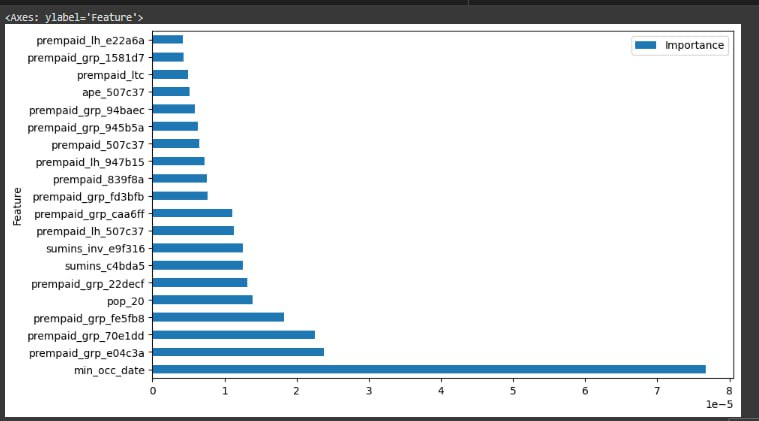

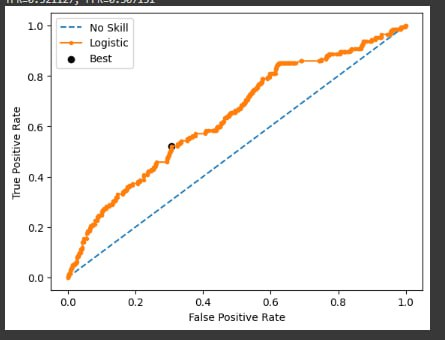

### Performance Evaluation

In [ ]:
def final_predicts(p1, p2, p3):
  models_output = pd.DataFrame({'p1': p1, 'p2': p2, 'p3': p3})
  final_prediction = models_output.mode()
  return final_prediction.values.tolist()[0]

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''
    df = hidden_data
    df.to_csv("raw_df.csv", index=False)
    xgb_predicted = xgb_pred.predict(df)
    dt_predicted = dt_pred.predict(df)
    log_reg_predicted = log_reg_pred.predict(df)
    result = final_predicts(xgb_predicted, dt_predicted, log_reg_predicted)
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!